In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window
from scipy.stats import linregress
from scipy.interpolate import interp1d

In [2]:
healthy_dir = "../../data/open_vag/normal/"
pathology_dir = "../../data/open_vag/pathology/"
#healthy_base = "novag"
#pathology_base  = "abvag"

healthy_subs = [] # 51
pathology_subs = [] # 38

exclude = {".ipynb_checkpoints"}

healthy_files = [f for f in os.listdir(healthy_dir) if '.ipynb_checkpoints' not in f]
print(f" healthy vag signals {len(healthy_files)}")
pathology_files = [f for f in os.listdir(pathology_dir) if '.ipynb_checkpoints' not in f]
print(f" pathology vag signals {len(pathology_files)}")

max_size_files = max(len(healthy_files), len(pathology_files))

for i in range(0, max_size_files):
    if(i < len(healthy_files)):
        # read in a healthy_file
        file_path = os.path.join(healthy_dir, healthy_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            healthy_subs.append(vags)
    if(i < len(pathology_files)):
        file_path = os.path.join(pathology_dir, pathology_files[i])
        with open(file_path, 'r') as file:
            # Read all the floating-point numbers into a list
            vags = [float(x) for x in file.read().split()]
            pathology_subs.append(vags)   

 healthy vag signals 51
 pathology vag signals 38


### Resample and plot a known signal

- https://www.ee.ryerson.ca/~krishnan/person/VAG.html
- note it looks like resampling means adding 0's to the end

In [3]:
n_norm_res = []
p_norm_res = []
p_padded = []
n_l = 8192 #8192  # next fft points value int(math.pow(2, math.ceil(math.log2(len(data)))))
fs = 2000
for d in healthy_subs:
    y_new = resample(d, n_l)
    n_norm_res.append(y_new)

for d in pathology_subs:
    y_new = resample(d, n_l)
    p_norm_res.append(y_new)
    # add zeros instead
    pad = n_l - len(d)
    padded_p = np.pad(d, (0, pad), 'constant')
    p_padded.append(padded_p)

# plot the abnormal signals
#fig, ax = plt.subplots(len(p_norm_res),1, figsize=(20, 250))
#for i, d in enumerate(p_norm_res):
#    t_n = np.linspace(0, len(d), num=len(d))
#    ax[i].plot(t_n, d, color="m")



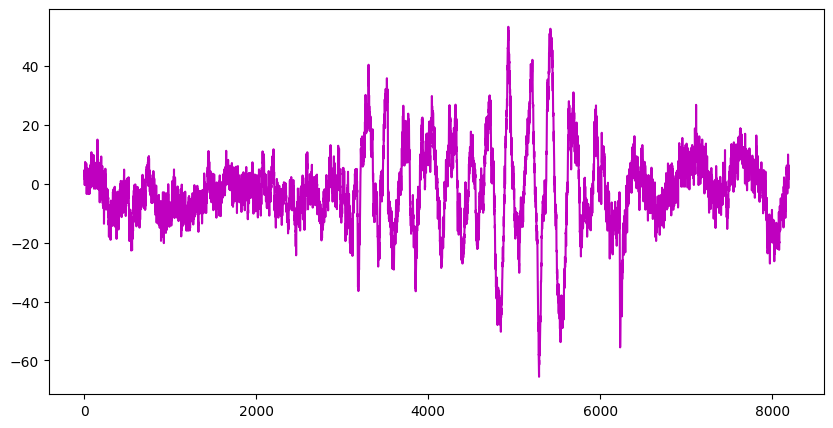

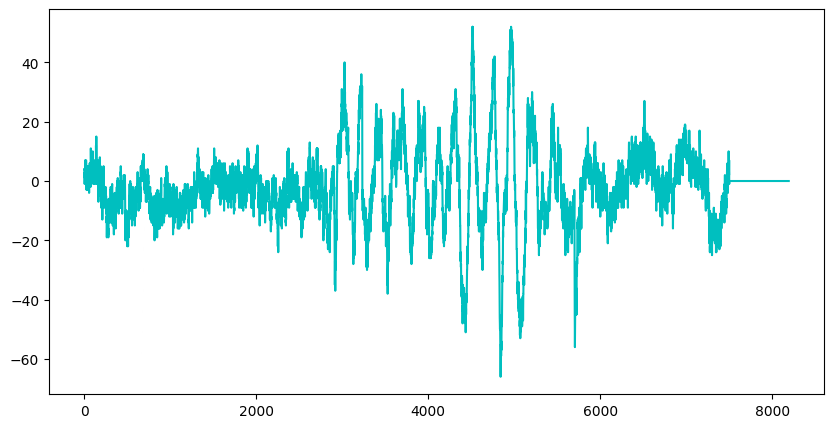

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

n=25
t_n = np.linspace(0, len(p_norm_res[n]), num=len(p_norm_res[n]))
ax.plot(t_n, p_norm_res[n], color="m")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))


t_n = np.linspace(0, len(p_padded[n]), num=len(p_padded[n]))
ax.plot(t_n, p_padded[n], color="c")

In [5]:

import librosa as lr
import numpy as np
import soundfile as sf

signal = p_padded[n]

# Normalize the signal to range [-1, 1]
#normalized_signal = signal / np.max(np.abs(signal))

# Save as an audio file
#sf.write('vag_2_ab.wav', normalized_signal, 2000)

In [6]:
#simple method that is really loud and noisy

import numpy as np
import soundfile as sf

fs = 2000  # Original sampling rate of acceleration data

n_samples = len(signal)

# Compute the duration of the signal
duration = n_samples / fs  # Duration in seconds

# Generate the correct time vector
t = np.linspace(0, duration, n_samples, endpoint=False)

# Frequency mapping: map acceleration values to a frequency range (e.g., 100 Hz to 1000 Hz)
base_frequency = 10  # Lower bound of frequency
frequency_range = 900  # Frequency range (from 100 Hz to 1000 Hz)

# Map the normalized data to this frequency range
normalized_acceleration = signal / np.max(signal)
frequencies = base_frequency + frequency_range * normalized_acceleration
# Generate audio signal based on frequency modulation
audio_signal = np.sin(2 * np.pi * frequencies * t)

# Normalize audio signal to range [-1, 1]
audio_signal /= np.max(np.abs(audio_signal))

# Write to an audio file
sf.write('sonified_acceleration_frequency_mapped.wav', audio_signal, fs)
print("Sonified (frequency-mapped) audio saved as 'sonified_acceleration_frequency_mapped.wav'")


Sonified (frequency-mapped) audio saved as 'sonified_acceleration_frequency_mapped.wav'


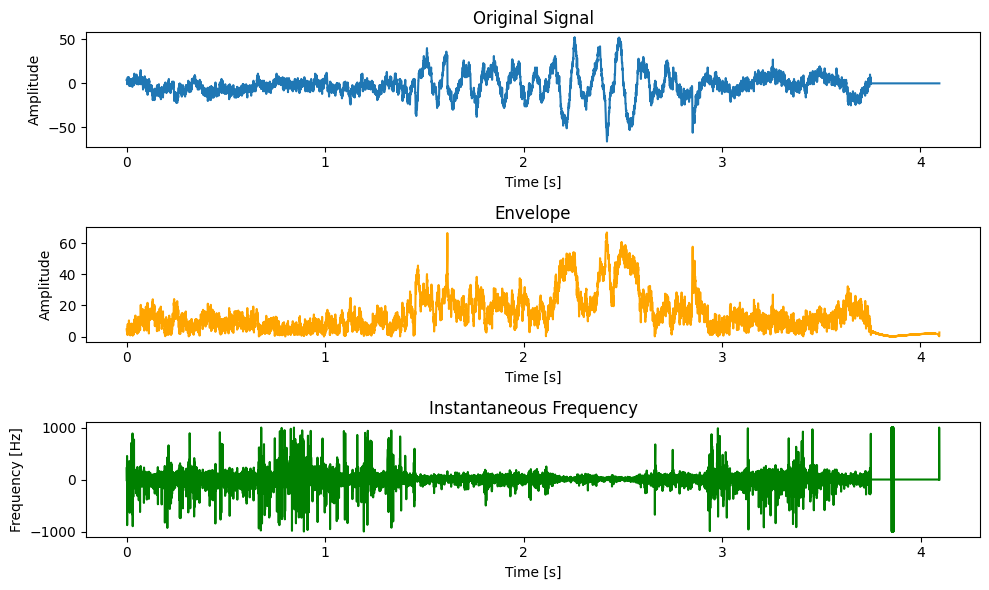

In [7]:
import numpy as np
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Simulated signal (replace this with your actual acceleration data)
sampling_rate = 2000  # Hz

# Step 1: Compute the analytic signal using Hilbert transform
analytic_signal = hilbert(signal)

# Step 2: Extract the envelope (magnitude of the analytic signal)
envelope = np.abs(analytic_signal)

# Step 3: Compute the instantaneous phase
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

# Step 4: Compute the instantaneous frequency
instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * (1.0 / sampling_rate))

# Plotting the results
plt.figure(figsize=(10, 6))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(t, signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Envelope of the signal
plt.subplot(3, 1, 2)
plt.plot(t, envelope, label='Envelope', color='orange')
plt.title('Envelope')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')

# Instantaneous frequency
plt.subplot(3, 1, 3)
plt.plot(t[:-1], instantaneous_frequency, label='Instantaneous Frequency', color='green')
plt.title('Instantaneous Frequency')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')

plt.tight_layout()
plt.show()


In [14]:
from scipy.io.wavfile import write
import soundfile as sf

# Step 4: Normalize frequency to sound pitch range (e.g., 200 Hz to 1000 Hz)
freq_min = 200  # Hz (low pitch)
freq_max = 1000 # Hz (high pitch)
#normalized_frequency = np.clip(instantaneous_frequency, 0, freq_max)
normalized_frequency = freq_min + (normalized_frequency - normalized_frequency.min()) / (normalized_frequency.max() - normalized_frequency.min()) * (freq_max - freq_min)

# Step 5: Normalize the envelope to amplitude range (0.0 to 1.0)
normalized_envelope = envelope / np.max(envelope)

# Step 6: Generate sound signal from frequency and envelope
sound_signal = np.sin(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate) * normalized_envelope

# Step 7: Save the generated sound as a WAV file
# Ensure the sound is scaled between -1 and 1
#sound_signal = np.int16(sound_signal / np.max(np.abs(sound_signal)) * 32767)
sf.write('sonified_output.wav', sound_signal, sampling_rate)

print("Sonification complete. The audio file 'sonified_output.wav' has been created.")

Sonification complete. The audio file 'sonified_output.wav' has been created.


In [49]:
import numpy as np
from scipy.signal import sawtooth, square


# Step 4: Normalize frequency to sound pitch range (e.g., 200 Hz to 1000 Hz)
freq_min = 200   # Hz (low pitch)
freq_max = 1000  # Hz (high pitch)
normalized_frequency = np.clip(instantaneous_frequency, 0, freq_max)
normalized_frequency = freq_min + (normalized_frequency - normalized_frequency.min()) / (normalized_frequency.max() - normalized_frequency.min()) * (freq_max - freq_min)

# Step 6: Generate sound signal from frequency and envelope using different waveforms

# Sine wave (as used before):
sound_sine = np.sin(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate)

# Square wave:
sound_square = square(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate)

# Sawtooth wave:
sound_sawtooth = sawtooth(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate)

# Triangle wave (sawtooth with width=0.5 is equivalent to a triangle wave):
sound_triangle = sawtooth(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate, width=0.5)


# Multiply by envelope to apply volume dynamics (optional):
sound_sine = sound_sine * normalized_envelope
sound_square = sound_square * normalized_envelope
sound_sawtooth = sound_sawtooth * normalized_envelope

# Select the sound you want to save (e.g., sawtooth):
sound_signal = sound_triangle

# Design a bandpass filter
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Bandpass filter
    filtered_signal = filtfilt(b, a, signal)  # Apply the filter
    return filtered_signal

# Apply the filter to the sound (allow 200 Hz to 1000 Hz to pass)
lowcut_frequency = 100  # Hz
highcut_frequency = 500  # Hz
filtered_sound = bandpass_filter(sound_signal, lowcut_frequency, highcut_frequency, sampling_rate)

# Step 7: Save the generated sound as a WAV file
#sound_signal = np.int16(sound_signal / np.max(np.abs(sound_signal)) * 32767)  # Scale to 16-bit PCM
sf.write('sonified_sawtooth_output.wav', filtered_sound, sampling_rate)

print("Sonification complete. The audio file 'sonified_sawtooth_output.wav' has been created.")


Sonification complete. The audio file 'sonified_sawtooth_output.wav' has been created.


In [45]:
# Step 4: Normalize frequency to sound pitch range (e.g., 200 Hz to 1000 Hz)
freq_min = 200   # Hz (low pitch)
freq_max = 1000  # Hz (high pitch)
normalized_frequency = np.clip(instantaneous_frequency, 0, freq_max)
normalized_frequency = freq_min + (normalized_frequency - normalized_frequency.min()) / (normalized_frequency.max() - normalized_frequency.min()) * (freq_max - freq_min)

# Step 6: Generate harmonic-rich sound by adding multiple harmonics

# Fundamental harmonic (sine wave at normalized frequency)
harmonic1 = np.sin(2 * np.pi * np.cumsum(np.concatenate(([0], normalized_frequency))) / sampling_rate)

# Second harmonic (twice the frequency, half the amplitude)
harmonic2 = 0.5 * np.sin(2 * np.pi * np.cumsum(np.concatenate(([0], 2 * normalized_frequency))) / sampling_rate)

# Third harmonic (three times the frequency, one-third the amplitude)
harmonic3 = 0.33 * np.sin(2 * np.pi * np.cumsum(np.concatenate(([0], 3 * normalized_frequency))) / sampling_rate)

# Combine harmonics to form a complex wave
sound_harmonic = harmonic1 + harmonic2 + harmonic3

# Multiply by envelope to apply volume dynamics (optional)
sound_harmonic = sound_harmonic * normalized_envelope

# Design a low-pass filter
def low_pass_filter(signal, cutoff_freq, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    normal_cutoff = cutoff_freq / nyquist  # Normalized cutoff frequency
    b, a = butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    filtered_signal = filtfilt(b, a, signal)  # Apply the filter
    return filtered_signal

# Apply the filter to the sound (cutoff frequency set to 800 Hz)
cutoff_frequency = 800  # Hz (you can adjust this value based on the noise)
filtered_sound = low_pass_filter(sound_harmonic, cutoff_frequency, sampling_rate)

# Design a bandpass filter
def bandpass_filter(signal, lowcut, highcut, sampling_rate, order=4):
    nyquist = 0.5 * sampling_rate  # Nyquist frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')  # Bandpass filter
    filtered_signal = filtfilt(b, a, signal)  # Apply the filter
    return filtered_signal

# Apply the filter to the sound (allow 200 Hz to 1000 Hz to pass)
lowcut_frequency = 100  # Hz
highcut_frequency = 500  # Hz
#filtered_sound = bandpass_filter(sound_harmonic, lowcut_frequency, highcut_frequency, sampling_rate)


# Step 8: Save the filtered sound as a WAV file
filtered_signal = np.int16(filtered_sound / np.max(np.abs(filtered_sound)) * 32767)  # Scale to 16-bit PCM
sf.write('sonified_filtered_output.wav', filtered_signal, sampling_rate)

print("Sonification complete. The filtered audio file 'sonified_filtered_output.wav' has been created.")

Sonification complete. The filtered audio file 'sonified_filtered_output.wav' has been created.
